In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

# clean data of listings table
listings['price'] = listings['price'].str.replace('$', '', regex=False)
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].astype('float')

# get rid of alienation
listings.drop(listings[listings['accommodates'] == 0].index, inplace=True) # delete rows where accommodates = 0


# clean calendar table
calendar['price'] = calendar['price'].str.replace('$', '', regex=False)
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].astype('float')

calendar['adjusted_price'] = calendar['adjusted_price'].str.replace('$', '', regex=False)
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace(',', '')
calendar['adjusted_price'] = calendar['adjusted_price'].astype('float')

calendar['date'] = pd.to_datetime(calendar['date'])

calendar.loc[calendar['available'] == 't', 'available'] = 1
calendar.loc[calendar['available'] == 'f', 'available'] = 0
calendar['available'] = pd.to_numeric(calendar['available'])


In [3]:
# define function to find outliers
def find_outliers_IQR(ser:pd.Series, return_filter=False):
   """Take a seri in and return a seri of outliers via IQR method \n
   If return_filter=True -> return a seri of booleans
   """
   q1=ser.quantile(0.25)
   q3=ser.quantile(0.75)
   IQR=q3-q1

   filterer = ((ser<(q1-1.5*IQR)) | (ser>(q3+1.5*IQR)))
   outliers = ser[filterer]

   if return_filter:
      return filterer
   else: return outliers

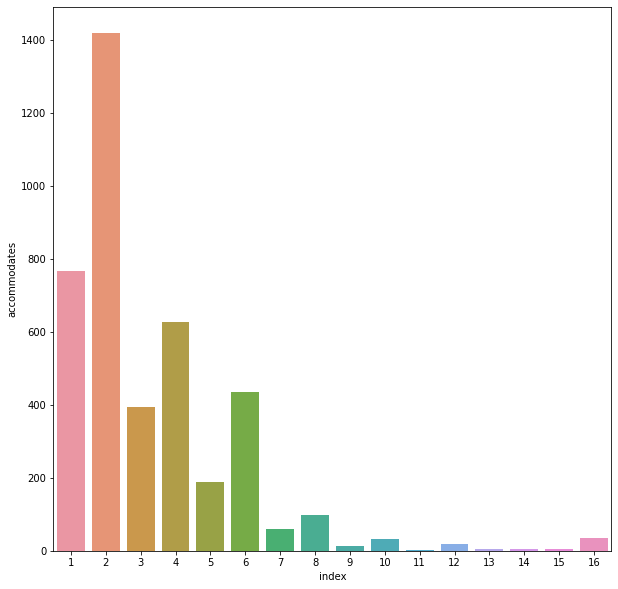

In [13]:
# grouping the number of accommodates
accomodate_no = listings['accommodates'].value_counts()
accomodate_no = accomodate_no.reset_index()

plt.figure(figsize=[10,10])
sns.barplot(data=accomodate_no, x='index', y='accommodates')
plt.show()

In [5]:
# decide number of accomodates into 4 groups
listings.loc[listings['accommodates'] == 1, 'accommodates_group'] = '1'
listings.loc[listings['accommodates'] == 2, 'accommodates_group'] = '2'
listings.loc[(listings['accommodates'] >= 3) & (listings['accommodates'] <= 6), 'accommodates_group'] = '3-6'
listings.loc[listings['accommodates'] >= 7, 'accommodates_group'] = '>= 7'

listing_type = listings[['id', 'bedrooms', 'beds', 'accommodates_group']].set_index('id')

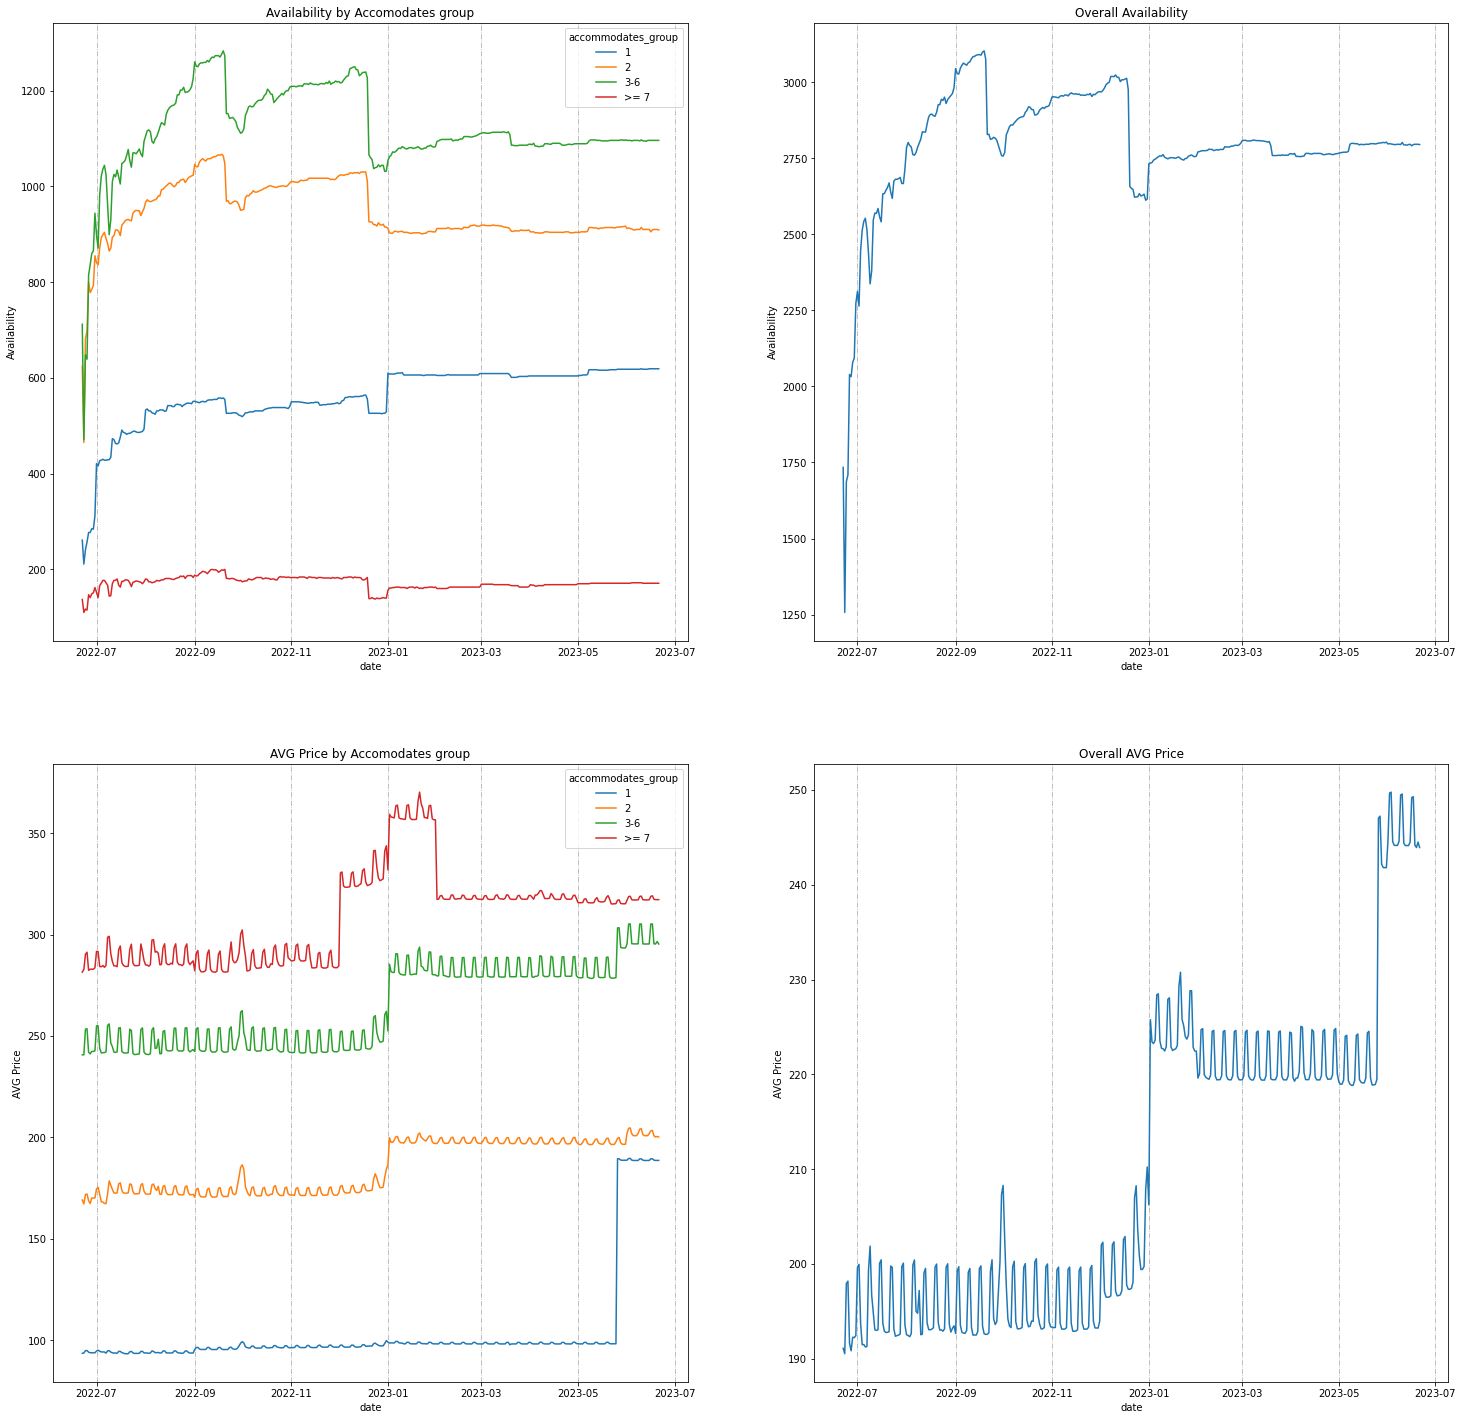

In [90]:
tmp = calendar.copy().set_index('listing_id')

visual_acco_group = tmp.join(listing_type).rename_axis('id').reset_index()
visual_acco_group_sum = visual_acco_group.groupby(['date', 'accommodates_group'])[['available', 'adjusted_price']].sum().reset_index()
visual_acco_group_mean = visual_acco_group.groupby(['date', 'accommodates_group'])[['available', 'adjusted_price']].mean().reset_index()

plt.figure(figsize=(25, 25))

plt.subplot(221)
sns.lineplot(data=visual_acco_group_sum, x='date', y='available', hue='accommodates_group')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('Availability')
plt.title('Availability by Accomodates group')

plt.subplot(222)
sns.lineplot(data=calendar.groupby('date')['available'].sum().reset_index(), x='date', y='available')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('Availability')
plt.title('Overall Availability')

plt.subplot(223)
sns.lineplot(data=visual_acco_group_mean, x='date', y='adjusted_price', hue='accommodates_group')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('AVG Price')
plt.title('AVG Price by Accomodates group')

plt.subplot(224)
sns.lineplot(data=calendar.groupby('date')['adjusted_price'].mean().reset_index(), x='date', y='adjusted_price')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('AVG Price')
plt.title('Overall AVG Price')

plt.show()

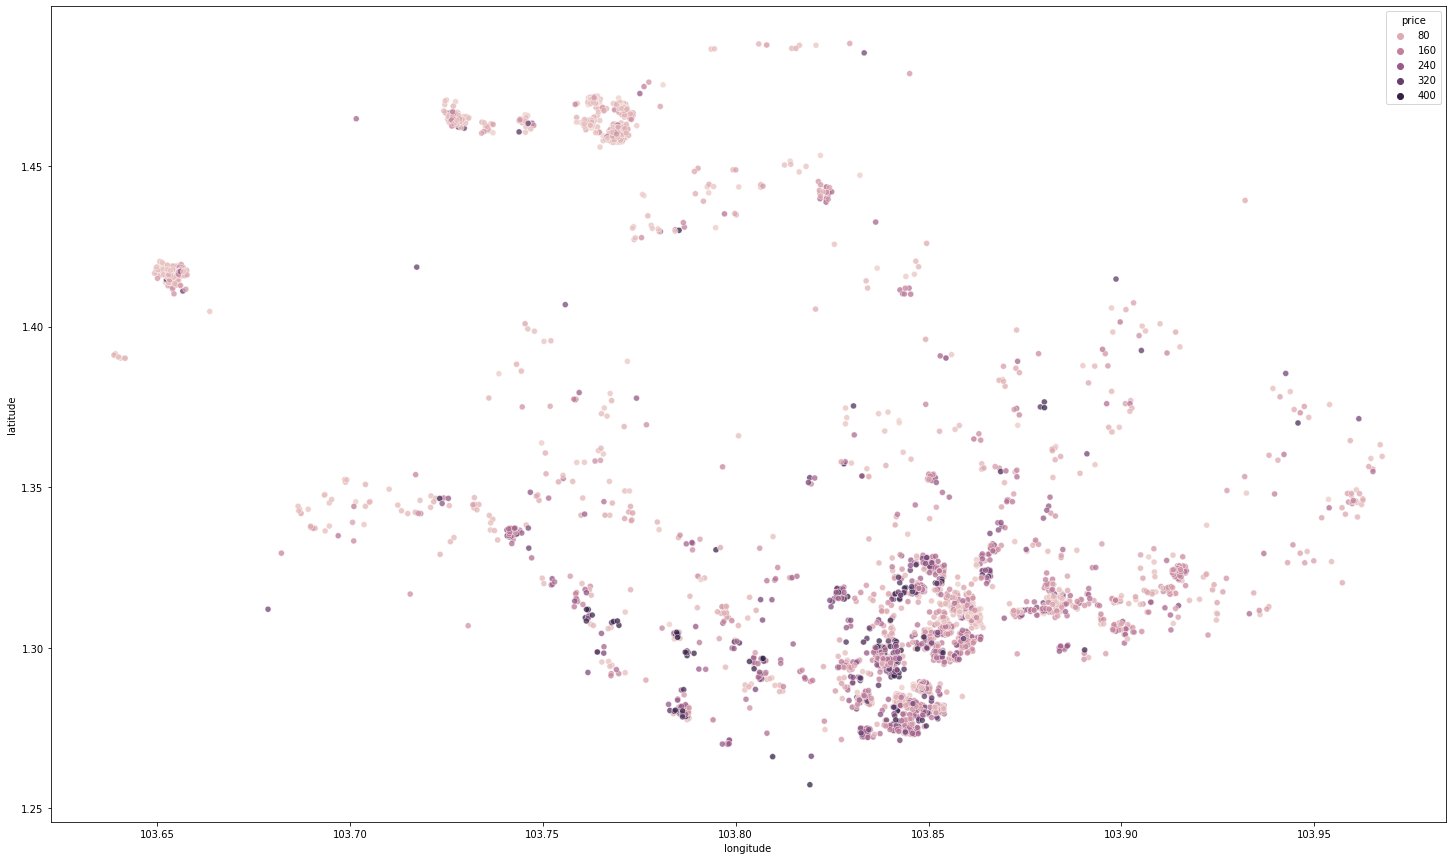

In [33]:
visual_price = listings[['latitude', 'longitude', 'price']].copy()

# remove outliers
visual_price = visual_price[~find_outliers_IQR(visual_price['price'], return_filter=True)]

plt.figure(figsize=(25, 15))
sns.scatterplot(data=visual_price, y='latitude', x='longitude', hue='price', alpha=0.75)
plt.show()

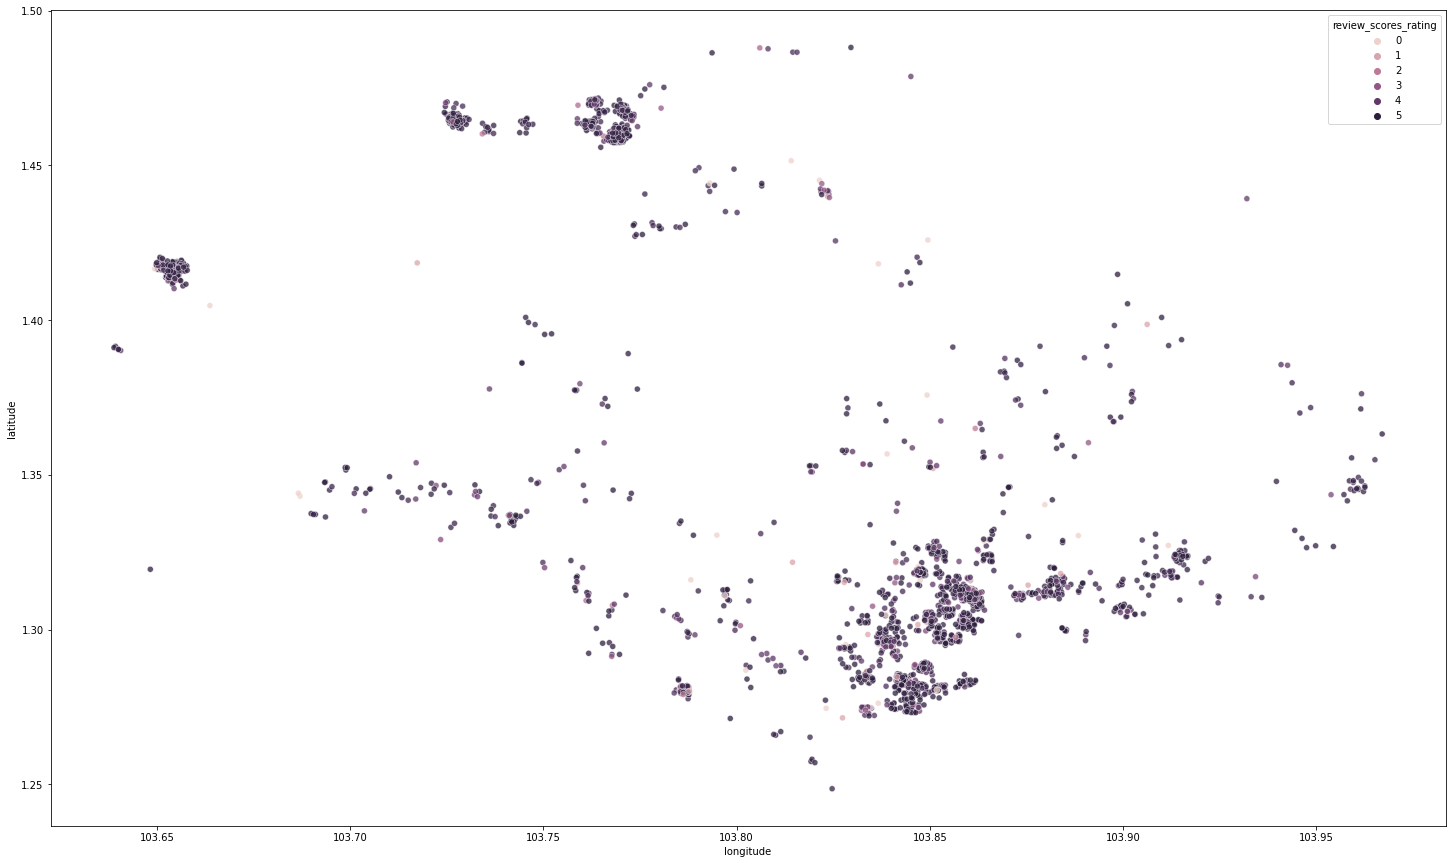

In [31]:
visual_review = listings[['latitude', 'longitude', 'review_scores_rating']].copy()

visual_review['review_scores_rating'] = visual_review['review_scores_rating'].astype('float')

plt.figure(figsize=(25, 15))
sns.scatterplot(data=visual_review, x='longitude', y='latitude', hue='review_scores_rating', alpha=0.75)
plt.show()